# Exploration des données

### Données obenues auprès de https://world.openfoodfacts.org


### Objectif du présent document

Explorer le jeu de données nettoyé dans le cadre d'une analyse univariée, bivariée et exploratoire des variables pertinentes retenues lors de la phase de préparation des données.


### Contexte de réalisation de l'étude

Notre étude du jeu de données devra être simple à comprendre pour un public néophyte. 
Nous devrons donc être particulièrement attentifs à la lisibilité et aux choix des graphiques pour illustrer notre propos.
    
### Direction de l'étude

Après une analyse univariée et bivariée du jeu de données, nous pourrons réaliser une ACP afin de comprendre les caractéristiques les plus discriminantes de notre ensemble de produits, ainsi qu'un partitionnement afin de plus simplement 
catégoriser les produits (beaucoups de catégories présentes dans le jeu).

Aussi nous pourrons effectuer quelques régressions pour étudier par exemple la correspondance entre nutriscore et nombre d'ingrédients dans un produit, la présence d'additifs ou d'allergènes.

Enfin, nous proposerons une métrique rendant compte de la qualité intrinsèque des produits, ainsi que de leur impact sur l'environnement, une métrique qui se voudra plus transparente envers le consommateur sur le bien fondé de la proposition de valeur qu'ils représentent.

### Idée d'application

Nous proposons un outil permettant au consommateur de mieux apprécier la qualité des produits qu'il consomme, et qui sera principalement basé sur l'appréciation des critères suivants :
- Le nustricore (valeur numérique)
- Le critère NOVA qui range en 4 catégories les produits en fonction de leur taux de transformation industrielle
- La présence d'addifits, d'allergènes, d'ingrédidents issus de l'huile de palme
- La disparité entre l'origine du produit, son lieu de transformation et la FRANCE
- L'appartenance du produit à un label BIO ou qui s'engage à prendre mieux soin des consommateurs
- Le type de packaging utilisé pour conditionner le produit

## Analyse univariée des valeurs nutritionnelles

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import anderson, levene, kruskal

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import ACP_functions
import missingno as msno

#### Chargement du jeu de données préparé

In [2]:
df_food = pd.read_csv('results\df_prepared.csv')
df_food.drop("Unnamed: 0", axis=1, inplace=True)

C:\Users\jkomb\AppData\Local\Temp\ipykernel_8732\2187803986.py:1: DtypeWarning: Columns (21,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv('results\df_prepared.csv')


In [3]:
df_food['nutrition_grade_fr'] = df_food['nutrition_grade_fr'] .str.upper()
df = df_food.copy()

#### Créations des variables utiles

In [4]:
cols_pack = df.columns[df.columns.get_loc('carton'):df.columns.get_loc('suremballage')+1].tolist()
cols_categories = df.columns[df.columns.get_loc('categories_synth1'):df.columns.get_loc('categories_synth3')+1].tolist()
cols_labels = df.columns[df.columns.get_loc('bio_europe'):df.columns.get_loc('catégories_personnes')+1].tolist()
cols_ingredients = df.columns[df.columns.get_loc('ingredients_text'):df.columns.get_loc('ingredients_n')+1].tolist()
cols_allergens = df.columns[df.columns.get_loc('gluten'):df.columns.get_loc('moutarde')+1].tolist()
cols_additifs = df.columns[df.columns.get_loc('additives_n'):df.columns.get_loc('additif_niveau_danger')+1].tolist()
cols_palm = df.columns[df.columns.get_loc('ingredients_from_palm_oil_n'):df.columns.get_loc('ingredients_that_may_be_from_palm_oil_n')+1].tolist()
cols_nutri = df.columns[-8:].tolist()
cols_val_nutri = cols_nutri.copy()
cols_val_nutri.remove('nutrition-score-fr_100g')

nutriscore = 'nutrition-score-fr_100g'
nutrigrade = 'nutrition_grade_fr'

In [5]:
size_title_graph = 17
y_title = 1
dict_colors={'A':'#198e22', 'B':'#5fd167', 'C':'#e4ff00', 'D':'#ff5733', 'E':'#ff0000'}

#### Données générales sur le jeu de données préparé

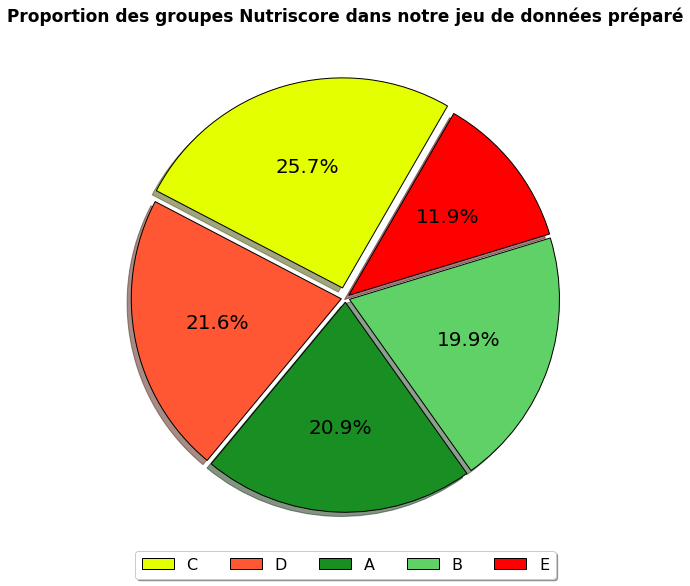

In [6]:
plt.figure(figsize=(8,8))
plt.suptitle('Proportion des groupes Nutriscore dans notre jeu de données préparé', size=size_title_graph, 
             va='top', weight='bold')

pie_datas = df[nutrigrade].value_counts().sort_values(ascending=False)
labels=df[nutrigrade].value_counts().sort_values(ascending=False).index

textprops = dict(size=20, color="black")
wedge_properties = {"edgecolor":"k",'linewidth': 1}

plt.pie(pie_datas, colors=[dict_colors[key] for key in labels],
        textprops=textprops,
        explode=[0.05,0.02,0.02,0.02,0.02],
        autopct='%1.1f%%',
        shadow=True, 
        wedgeprops=wedge_properties,
        startangle=60)

plt.tight_layout()
plt.legend(labels, loc="lower center", ncol=5, fontsize=16, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)
plt.savefig('img\\Proportion des groupes Nutriscore dans notre jeu de données préparé.png')

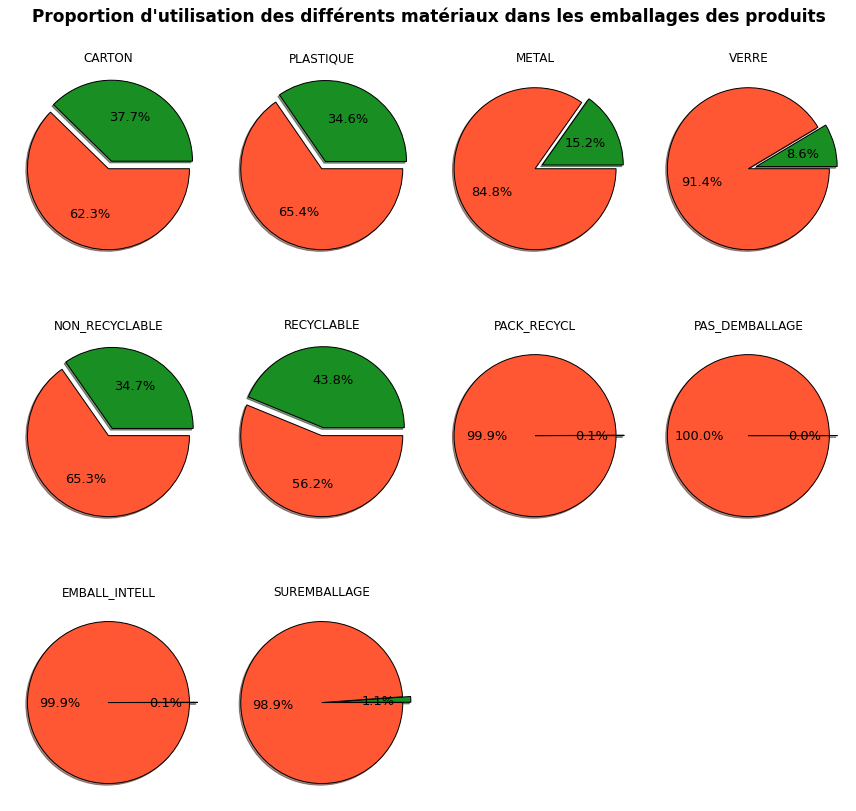

In [7]:
plt.figure(figsize=(12,12))
plt.suptitle("Proportion d'utilisation des différents matériaux dans les emballages des produits", size=size_title_graph, 
             va='top', weight='bold')
for col in cols_pack:
    plt.subplot(3,4, cols_pack.index(col)+1)
    plt.pie(x=df[col].value_counts().sort_values(ascending=True),
           colors=['#198e22', '#ff5733'],
           textprops=dict(size=13, color="black"),
           explode=[0.1,0],
           autopct='%1.1f%%',
           shadow=True, 
           wedgeprops=wedge_properties);
    plt.title(col.upper())

plt.tight_layout()
plt.savefig("img\\Proportion d'utilisation des différents matériaux dans les emballages des produits.png")

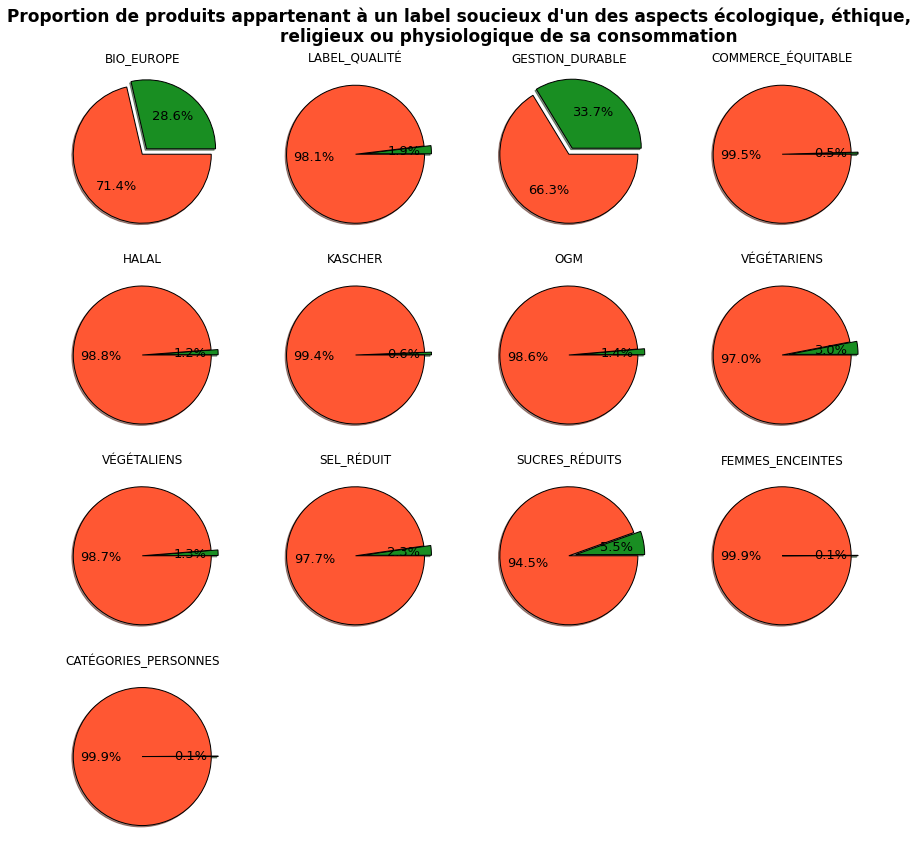

In [8]:
plt.figure(figsize=(12,12))
plt.suptitle("""Proportion de produits appartenant à un label soucieux d'un des aspects écologique, éthique, 
                religieux ou physiologique de sa consommation""",size=size_title_graph, va='top', weight='bold')
for col in cols_labels:
    plt.subplot(4,4, cols_labels.index(col)+1)
    plt.pie(x=df[col].value_counts().sort_values(ascending=True),
           colors=['#198e22', '#ff5733'],
           textprops=dict(size=13, color="black"),
           explode=[0.1,0],
           autopct='%1.1f%%',
           shadow=True, 
           wedgeprops=wedge_properties);
    plt.title(col.upper())

plt.tight_layout()
plt.savefig("img\\Proportion de produits appartenant à un label ou catégorie 'mieux consommer'.png")

* FEMMES_ENCEINTES = produits dont la consommation est déconseillé aux femmes enceintes
* CATÉGORIES_PERSONNES = produits dont la consommatione est déconseillé à certaines catégories de personnes

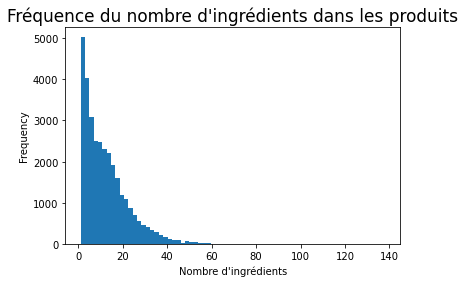

In [9]:
df[cols_ingredients[1]].plot.hist(bins=70)
plt.title("Fréquence du nombre d'ingrédients dans les produits", size=size_title_graph, y=y_title)
plt.xlabel("Nombre d'ingrédients")
plt.savefig("img\Fréquence du nombre d'ingrédients dans les produits.png")

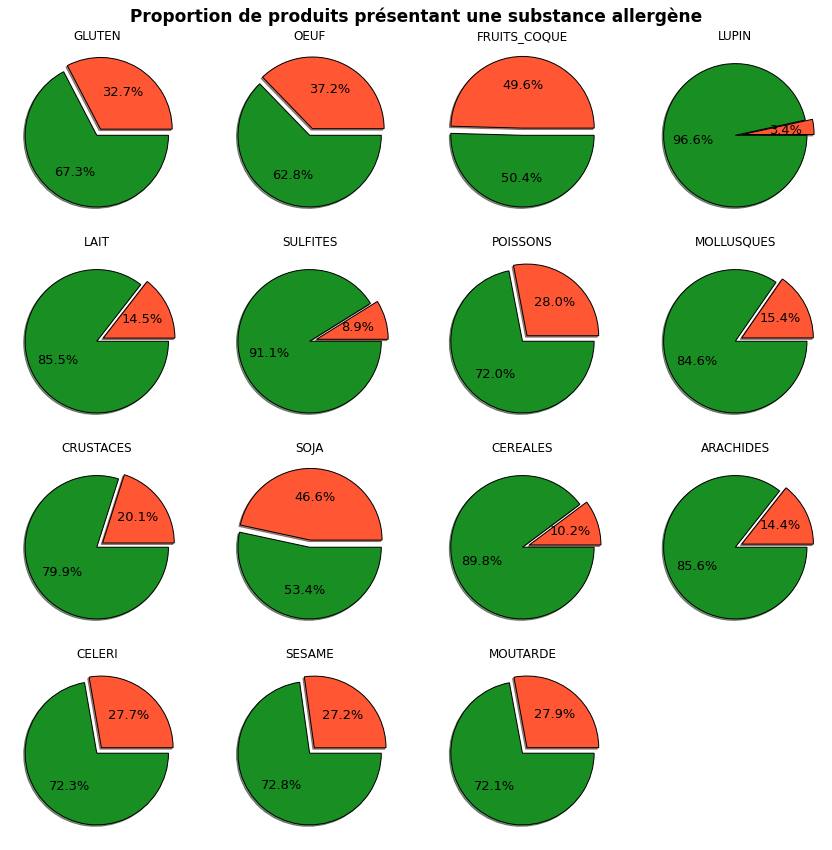

In [10]:
plt.figure(figsize=(12,12))
plt.suptitle("""Proportion de produits présentant une substance allergène""", size=size_title_graph, va='top', weight='bold')
for col in cols_allergens:
    plt.subplot(4,4, cols_allergens.index(col)+1)
    plt.pie(x=df[col].value_counts().sort_values(ascending=True),
           colors=['#ff5733', '#198e22'],
           textprops=dict(size=13, color="black"),
           explode=[0.1,0],
           autopct='%1.1f%%',
           shadow=True, 
           wedgeprops=wedge_properties);
    plt.title(col.upper())

plt.tight_layout()
plt.savefig("img\\Proportion de produits présentant une substance allergène.png")

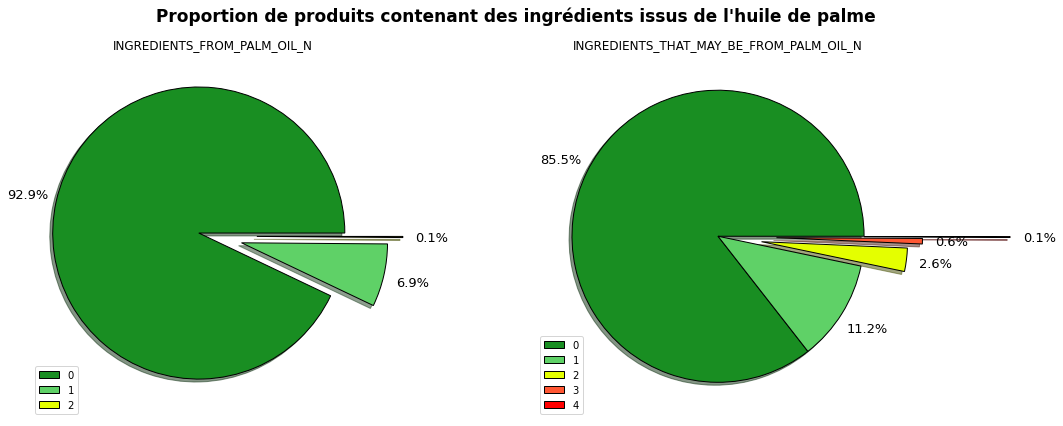

In [11]:
plt.figure(figsize=(16,6))
plt.suptitle("""Proportion de produits contenant des ingrédients issus de l'huile de palme""", size=size_title_graph, 
             va='top', weight='bold')
explode = [[0.1,0.2,0.3],[0,0,0.3,0.4,1]]
dict_colors_palm={0.0:'#198e22', 1.0:'#5fd167', 2.0:'#e4ff00', 3.0:'#ff5733', 4.0:'#ff0000'}
ax=dict()
for col in cols_palm:
    labels=df[col].dropna().astype(int).value_counts().sort_values(ascending=False).index
    plt.subplot(1,2, cols_palm.index(col)+1)
    plt.pie(x=df[col].value_counts().sort_values(ascending=False),
            colors=[dict_colors_palm[key] for key in df[col].value_counts().sort_values(ascending=False).index],
            textprops=dict(size=13, color="black"),
            explode=explode[df.columns.get_loc(col)-df.columns.get_loc(cols_palm[0])],
            autopct='%1.1f%%',
            shadow=True, 
            wedgeprops=wedge_properties,
            pctdistance=1.2
            )
    plt.title(col.upper())
    plt.legend(labels, loc='lower left')
    
plt.tight_layout()
plt.savefig("img\\Proportion de produits contenant des ingrédients issus de l'huile de palme.png")

#### Analyse univariée des variables nutritionnelles

Observons plus en détail les caractéristiques des distributions des valeurs nutritionnelles :

DISTRIBUTION DES VALEURS NUTRITIONNELLES


--------------------
ENERGY_100G


moyenne:
 894.8242014582067
médiane:
 698.0
mode:
 [0.]
variance:
 467256.91738459846
écart-type:
 683.5619338323328
skwewness:
 0.6784769271210634
kurtosis:
 -0.5771996524419354


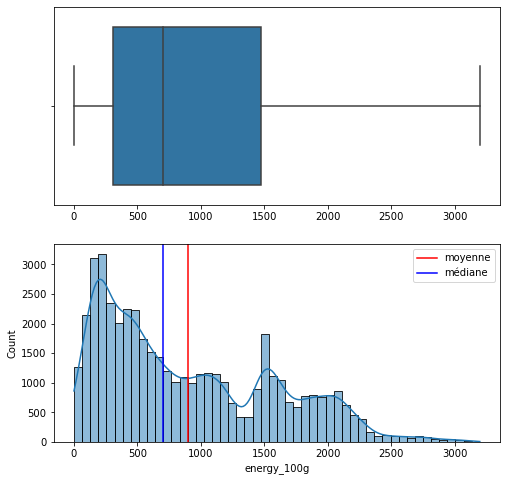

--------------------
SATURATED-FAT_100G


moyenne:
 3.160266755776442
médiane:
 1.4
mode:
 [0.]
variance:
 16.716508070373134
écart-type:
 4.088582648103513
skwewness:
 1.5766283174417473
kurtosis:
 1.5739241864977584


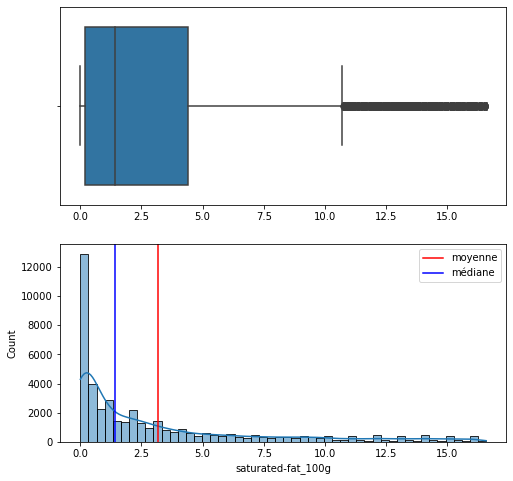

--------------------
CARBOHYDRATES_100G


moyenne:
 24.978850937212467
médiane:
 13.0
mode:
 [0.]
variance:
 645.7992773373986
écart-type:
 25.412581083734857
skwewness:
 0.9329524037262567
kurtosis:
 -0.5425094590348305


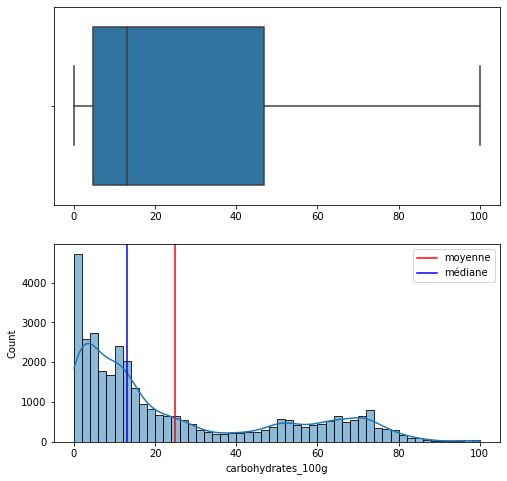

--------------------
SUGARS_100G


moyenne:
 8.213902012348147
médiane:
 3.7
mode:
 [0.]
variance:
 99.25066827420808
écart-type:
 9.962462962250253
skwewness:
 1.5202360349346151
kurtosis:
 1.344504900043574


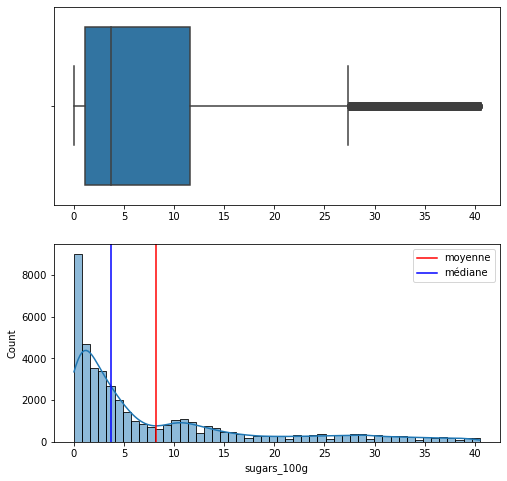

--------------------
FIBER_100G


moyenne:
 1.8421970752596728
médiane:
 1.4
mode:
 [0.]
variance:
 3.695680528555674
écart-type:
 1.9224152851441008
skwewness:
 1.0943843050728939
kurtosis:
 0.5429370927527524


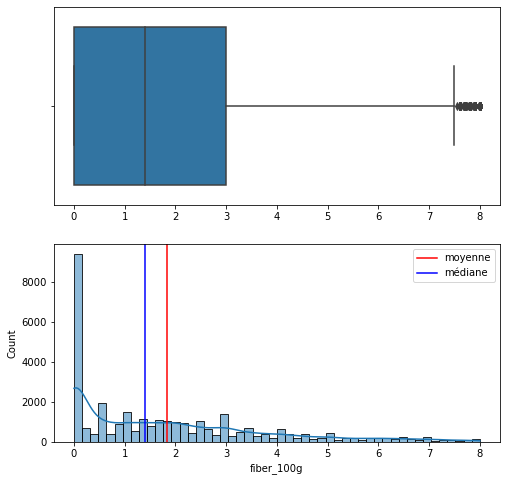

--------------------
PROTEINS_100G


moyenne:
 6.489336974441732
médiane:
 5.5
mode:
 [0.]
variance:
 31.922533892076764
écart-type:
 5.6500029992980325
skwewness:
 0.9505630271772301
kurtosis:
 0.22313026049630302


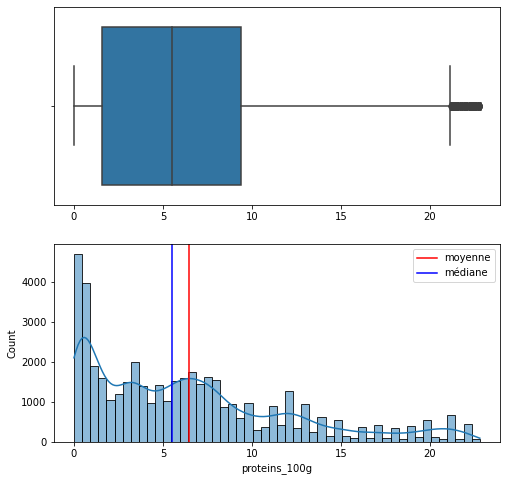

--------------------
SODIUM_100G


moyenne:
 0.27797927381235266
médiane:
 0.236220472440945
mode:
 [0.]
variance:
 0.07083474258759857
écart-type:
 0.26614797122577993
skwewness:
 0.8186990669767249
kurtosis:
 -0.13719441640525254


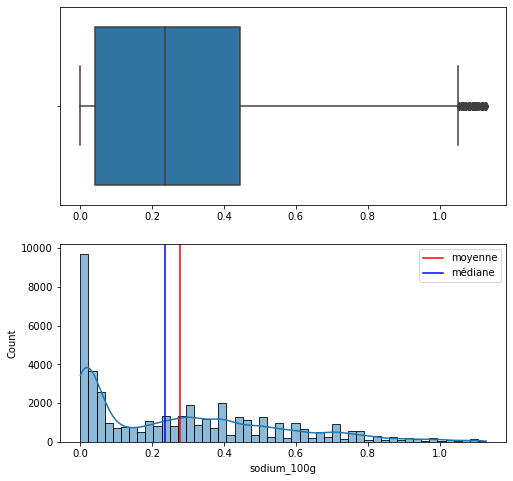

In [12]:
print('DISTRIBUTION DES VALEURS NUTRITIONNELLES')
print('\n')
for col in cols_val_nutri:
    subset = df[col]
    print("-"*20)
    print(col.upper())
    print('\n')
    print("moyenne:\n",subset.mean())
    print("médiane:\n",subset.median())
    print("mode:\n",subset.mode().values)
    print("variance:\n",subset.var(ddof=0))
    print("écart-type:\n",subset.std(ddof=0))
    print("skwewness:\n",subset.skew())
    print("kurtosis:\n",subset.kurtosis())
    fig = plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    ax1 = sns.boxplot(x=subset)
    ax1.set(xlabel=None)
    plt.subplot(2,1,2)
    ax2 = sns.histplot(x=df[col], kde=True, bins=50)
    plt.axvline(x=df[col].mean(), color='r', label='moyenne')
    plt.axvline(x=df[col].median(), color='b', label='médiane')
    plt.legend()
    plt.savefig(f"img\Distribution {col}.png")
    plt.show()

#### Étudions maintenant les corrélations entre les différentes variables nutritionnelles

In [13]:
# sns.pairplot(df[cols_nutri], kind='reg', diag_kind='kde')

Nous allons maintenant étudier plus particulièrement la relation entre le nutriscore et les valeurs nutritionnelles :

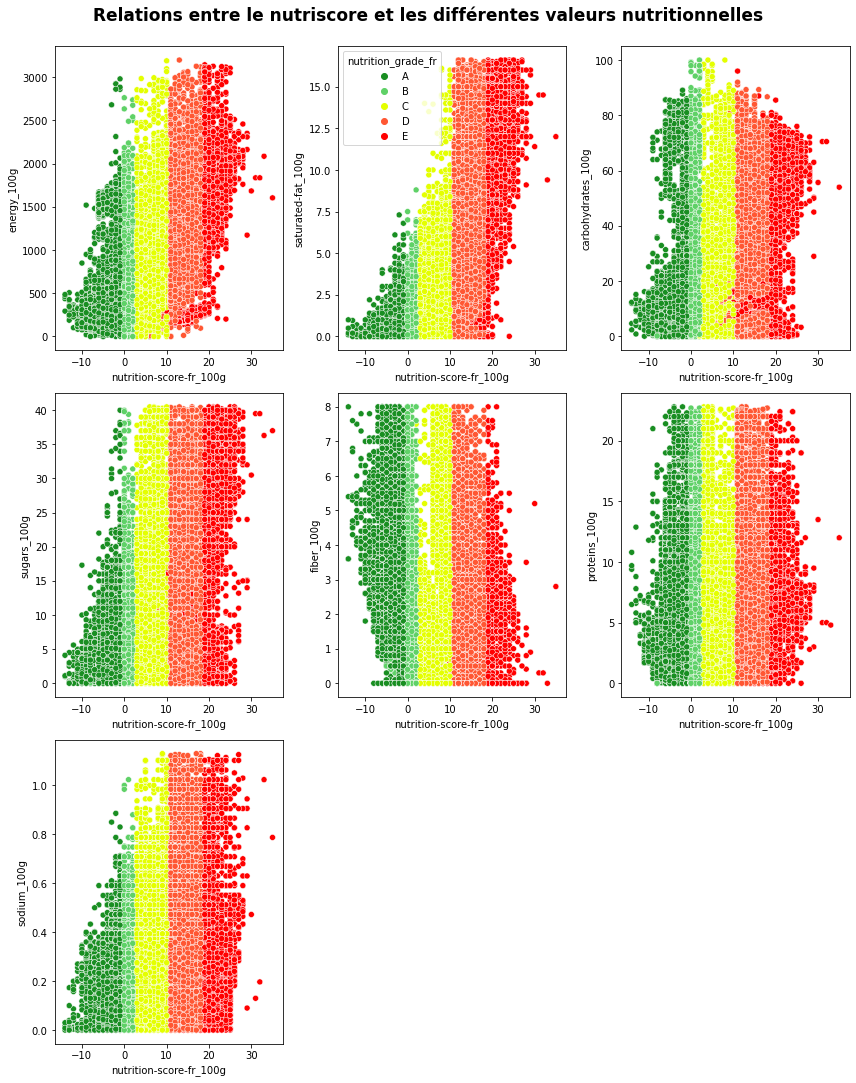

In [14]:
plt.figure(figsize=(12,15))
plt.suptitle('Relations entre le nutriscore et les différentes valeurs nutritionnelles', size=size_title_graph, va='top', 
             weight='bold', y=y_title)
hue = df[nutrigrade]

for col in cols_val_nutri:
    plt.subplot(3,3,cols_val_nutri.index(col)+1)
    if cols_val_nutri.index(col)==1:
        sns.scatterplot(data=df, x=nutriscore, y=col, 
                        hue=hue,
                        palette=dict_colors,
                        legend='brief')
    else:
        sns.scatterplot(data=df,
                        x=nutriscore, y=col, 
                        hue=hue,
                        palette=dict_colors,
                        legend=False)

plt.tight_layout()
plt.savefig('img\\Relations entre nutriscore et valeurs nutritionnelles.png')
plt.show();

Nous observons que :
- plus un produit est énergétique, plus son nutriscore a tendance à être élevé
- il en va de même pour la teneur en graisses saturées
- la tendance pour les glucides est moins prononcée, voire neutre
- plus un produit contient de sucres, plus son nutriscore a tendance à être élevé
- plus un produit contient de fibres, moins son nutriscore a tendance à être élevé
- de même que pour les glucides, la tendance pour les protéines semble neutre
- plus un produit contient de sodium, plus son nutriscore est élevé

Pour avoir une meilleure représentation des tendances qui semblent se dégager, nous préférons tracer ces relations sous forme de boîtes à moustaches comme ci-après :

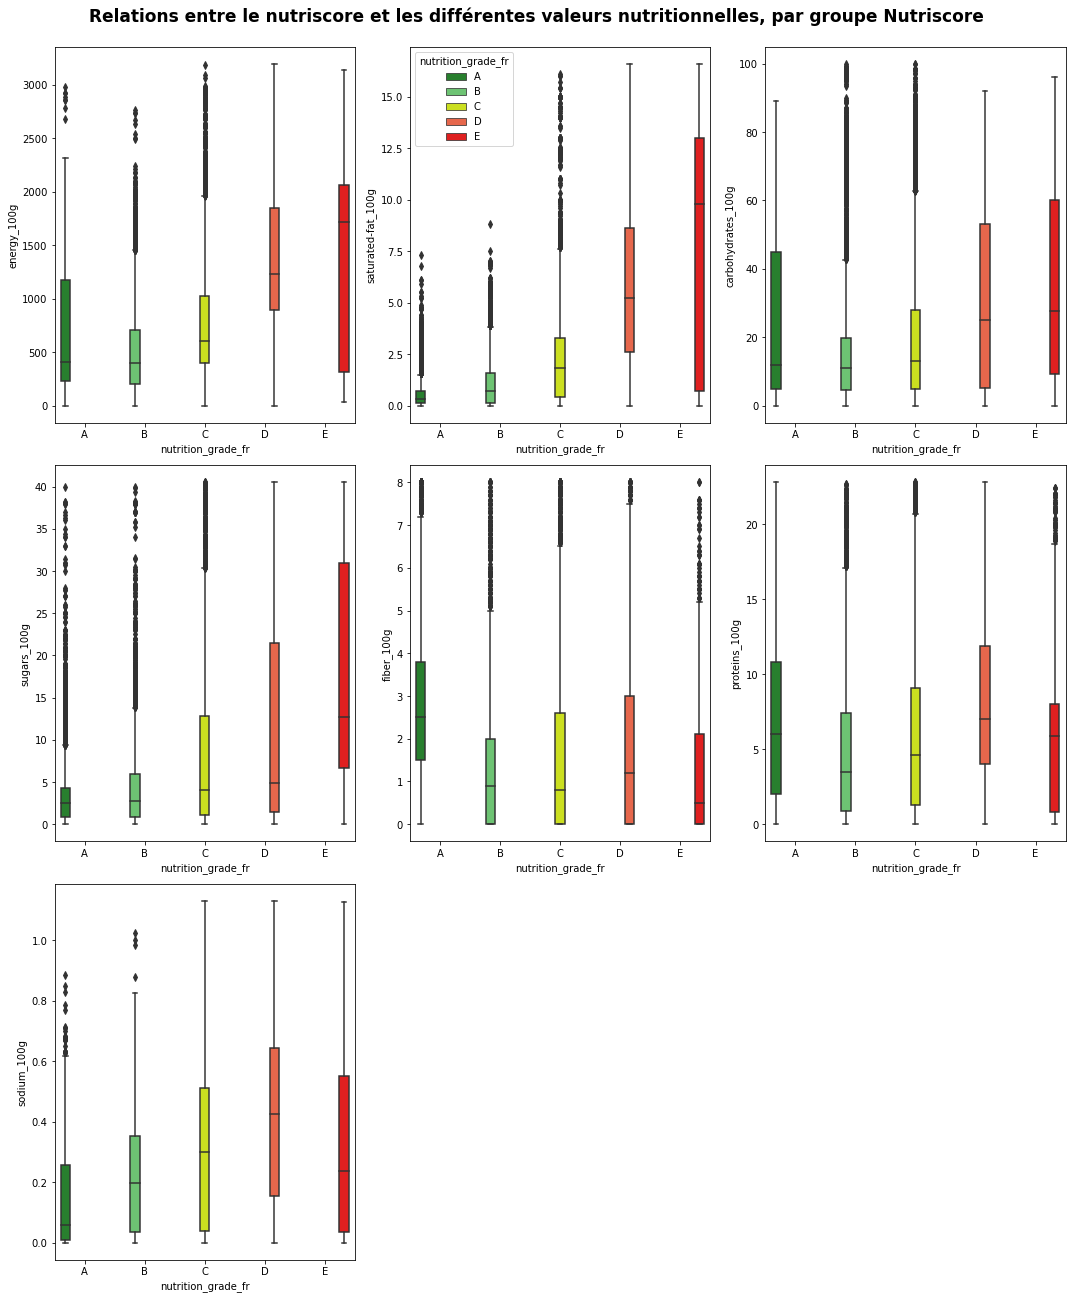

In [15]:
plt.figure(figsize=(15,18))
plt.suptitle('Relations entre le nutriscore et les différentes valeurs nutritionnelles, par groupe Nutriscore', 
             size=size_title_graph, y=y_title, va='top', weight='bold')

for col in cols_val_nutri:
    if cols_val_nutri.index(col)==1:
        plt.subplot(3,3,cols_val_nutri.index(col)+1)
        sns.boxplot(x=df[nutrigrade], y=df[col],
                            hue=hue,
                            palette=dict_colors)
    else:
        plt.subplot(3,3,cols_val_nutri.index(col)+1)
        sns.boxplot(x=df[nutrigrade], y=df[col],
                            hue=hue,
                            palette=dict_colors)
        plt.legend('',frameon=False)

plt.tight_layout()
plt.savefig('img\\Relations entre nutriscore et valeurs nutritionnelles, par groupe Nutriscore.png')
plt.show();

Nous allons évaluer si la moyenne des valeurs nutritionnelles sont significativement différentes dans chaque groupe Nutriscore, et allons donc réaliser pour cela une analyse de variance (ANOVA). Nous devons au préalable nous assurer que :

1. Pour chaque valeur nutritionnelle, les sous-échantillons correspondant aux différents groupes Nutriscore sont indépendants
1. Les distribution de ces échantillons doivent suivre une loi normale
2. Les écart-types de ces échantillons doivent être égaux


#### 2. Test de normalité de la distribution des valeurs nutritionnelles au sein des groupes Nutriscore

Nous testons la normalité des distributions à l'aide du <b>test d'Anderson</b>.

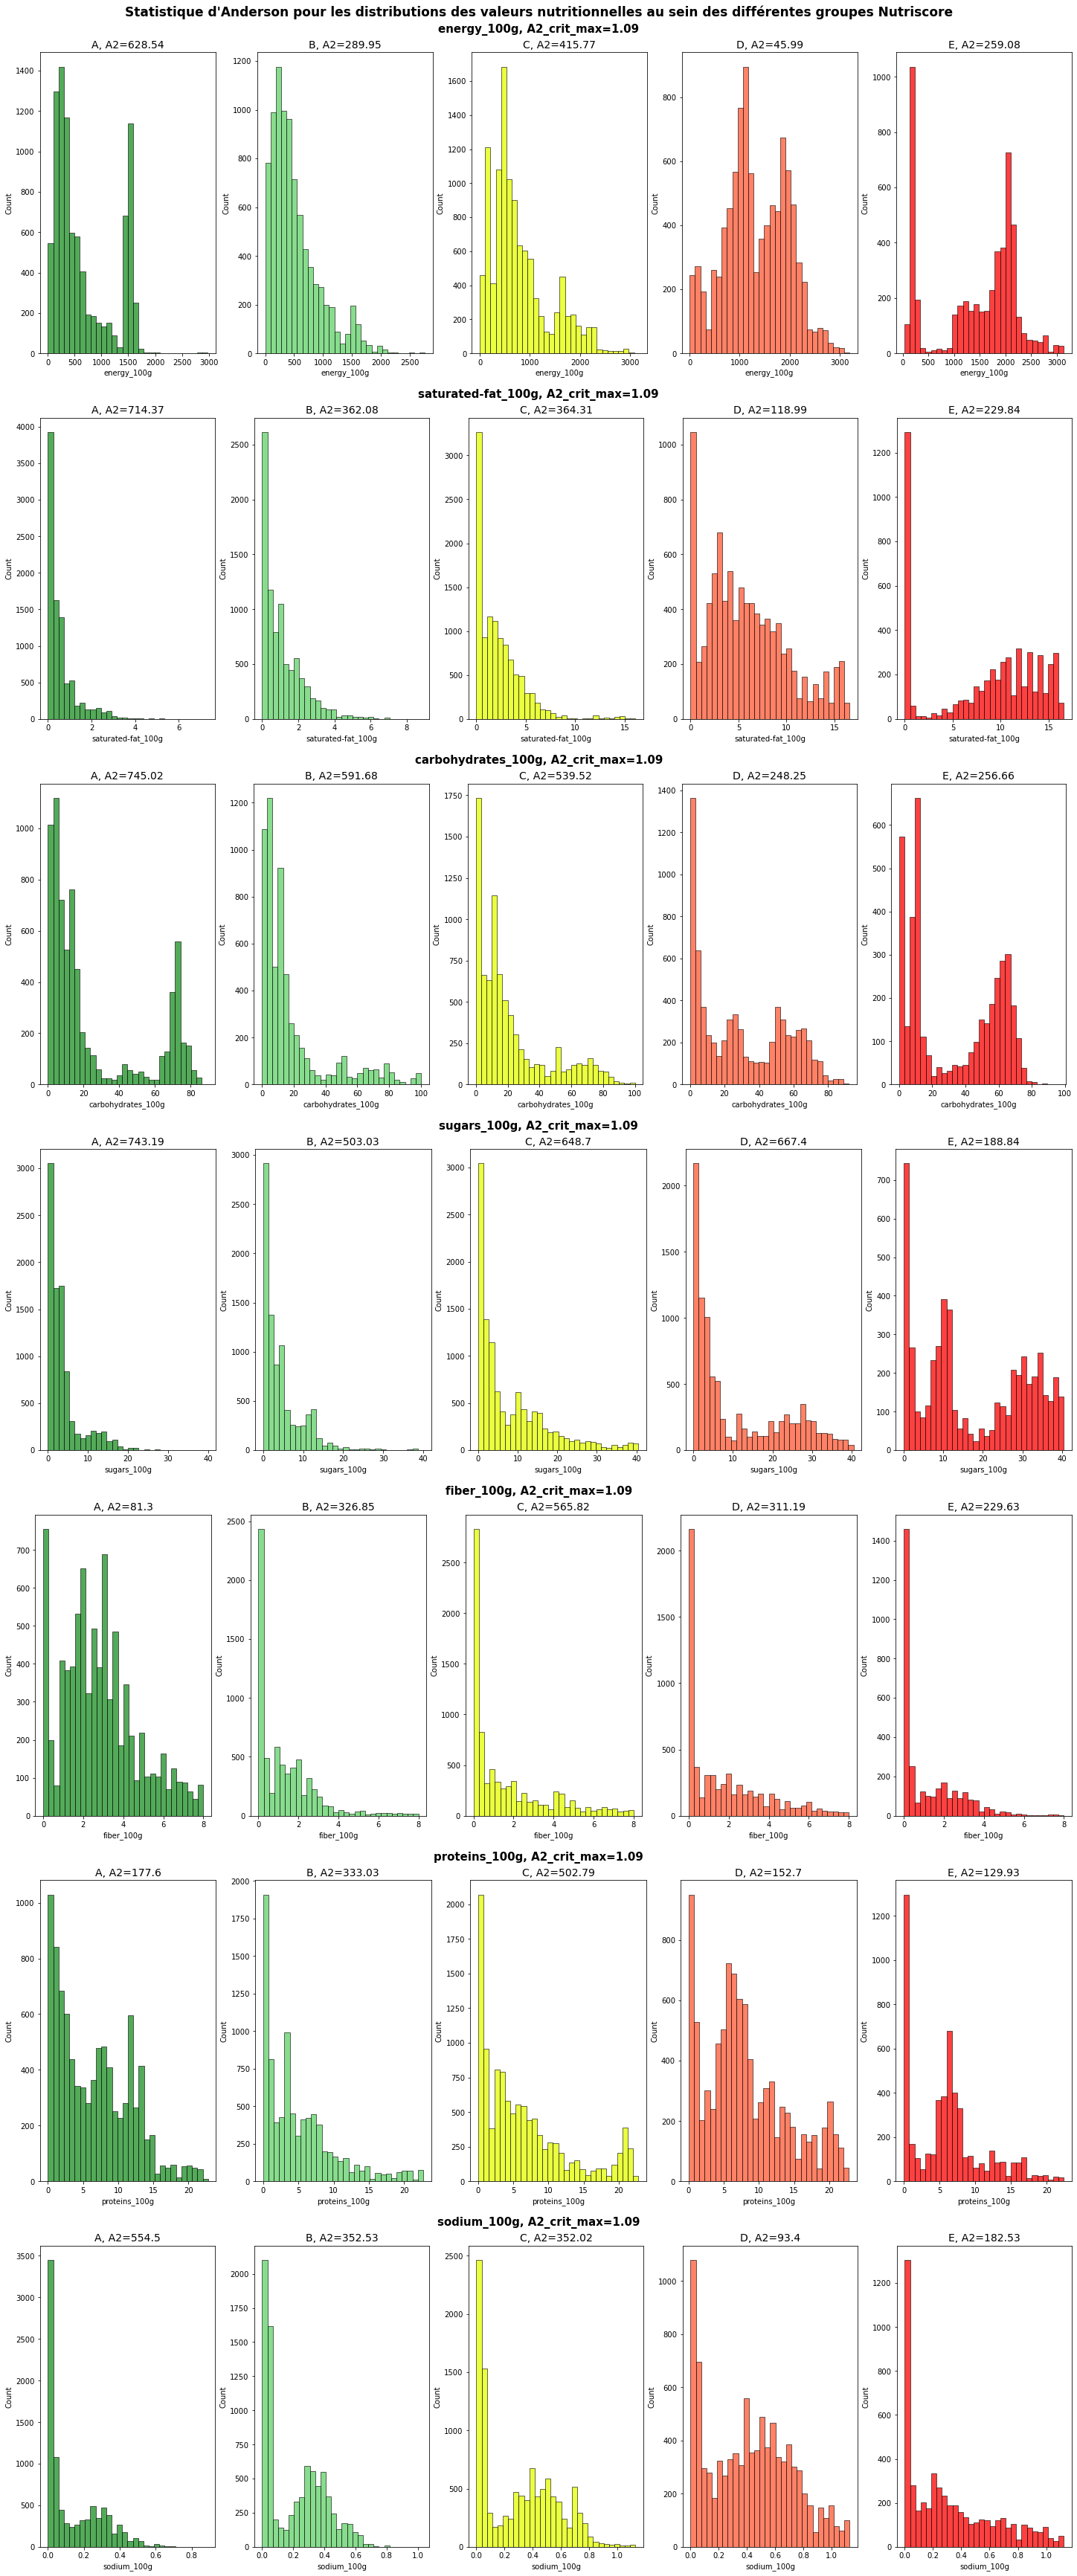

In [16]:
Nutriscore_groupes = df[nutrigrade].dropna().unique().tolist()
n = len(cols_val_nutri)
k = len(Nutriscore_groupes)

fig = plt.figure(figsize=(20, 48), constrained_layout=True)
fig.suptitle(
"""Statistique d'Anderson pour les distributions des valeurs nutritionnelles au sein des différentes groupes Nutriscore""",
    size=size_title_graph, va='top', weight='bold')
subfigs = fig.subfigures(n,1)

for i, subfig in enumerate(subfigs):
    val = cols_val_nutri[i]
    
    subset = df[[val, nutrigrade]].dropna()
    dict_Anderson = {Nutriscore_groupes[x]:np.round(anderson(subset[subset[nutrigrade]==Nutriscore_groupes[x]][val])[0],2)
                  for x in range(k)}
    dict_Anderson['A2_max'] = np.round(anderson(subset[subset[nutrigrade]=='A'][val])[1].max(),2)
    
    subfig.suptitle(f"{val}, A2_crit_max={dict_Anderson['A2_max']}", size=15, weight='bold')
    axs = subfig.subplots(1, k)
    
    for j, ax in enumerate(axs):
        grp = Nutriscore_groupes[j]
        
        ax.set_title(f"{grp}, A2={dict_Anderson[grp]}", size=14, y=1)
        sns.histplot(data=subset[subset[nutrigrade]==grp][val], ax=ax, bins=30, color=dict_colors[grp])
        
plt.savefig("img\Statistique d'Anderson pour les distributions des valeurs nutritionnelles au sein des différentes groupes Nutriscore.png")

Comme les histogrammes nous en laissaient douter,  <b>nous pouvons rejeter l'hypothèse de normalité des lois de distribution des sous-échantillons</b> car la statistique d'Anderson <b>A2</b> est chaque fois plus grande que la valeur critique maximale (celle qui s'en rapproche le plus est la distribution de la variable 'energy_100g' pour le groupe Nutriscore D).

Nous pensons que la grande quantité de produits présente dans les plages de très faibles valeurs dans toutes les valeurs nutritionnelles est une des principales sources de déviation de ces distributions d'une distribution gaussienne.

A ce stade, nous ne savons pas s'il s'agit de la conséquence d'un choix de traitement des données initiales (de type 'clip()') ou s'il s'agit d'un phénomène normal parmi les produits que l'on retrouve dans la grande distribution.

#### 3. Test d'homoscédasticité entre les sous-échantillons de chaque valeur nutritionnelle

Nous testons l'égalité des variances avec le <b>test de Levene</b> étant donné que nos sous-échantillons ne suivent pas une loi normale.

In [17]:
dict_Levene = {}
dict_samples_nutri = {}

for val in cols_val_nutri:

    subsets = {}
    
    for grp in Nutriscore_groupes:
        subsets[grp] = df[df[nutrigrade]==grp][val].dropna().reset_index(drop=True)
    
    dict_samples_nutri[val]=subsets
    dict_Levene[val]=levene(subsets['A'],subsets['B'],subsets['C'],subsets['D'],subsets['E'])

for key in dict_Levene.keys():
    print("La p-value associée au test d'égalité des variances de {} est {}.".format(key,dict_Levene[key].pvalue))

La p-value associée au test d'égalité des variances de energy_100g est 0.0.
La p-value associée au test d'égalité des variances de saturated-fat_100g est 0.0.
La p-value associée au test d'égalité des variances de carbohydrates_100g est 8.896777768562899e-304.
La p-value associée au test d'égalité des variances de sugars_100g est 0.0.
La p-value associée au test d'égalité des variances de fiber_100g est 7.406433836385036e-143.
La p-value associée au test d'égalité des variances de proteins_100g est 1.713225498835339e-92.
La p-value associée au test d'égalité des variances de sodium_100g est 0.0.


De toute évidence, la p-value associée à tous nos test d'égalité des variances entre les sous-échantillons des valeurs nutritionnelles en fonction du groupe Nutriscore est inférieure à la valeur seuil de <b>p=0.05</b>, <b>nous rejetons donc l'hypothèse d'égalité des écart-types</b>.

Étant donné la non réalisation des 2 conditions nécessaires pour effectuer un test ANOVA, nous proposons de réaliser un test de <b>Kruskal-Wallis<b/>:

In [18]:
dict_Kruskal = {}
for val in cols_val_nutri:
    subset = dict_samples_nutri[val]
    dict_Kruskal[val] = kruskal(subset['A'],subset['B'],subset['C'],subset['D'],subset['E'])

for key in dict_Kruskal.keys():
    print("La p-value associée au test d'égalité des médianes de {} est {}.".format(key,dict_Kruskal[key].pvalue))

La p-value associée au test d'égalité des médianes de energy_100g est 0.0.
La p-value associée au test d'égalité des médianes de saturated-fat_100g est 0.0.
La p-value associée au test d'égalité des médianes de carbohydrates_100g est 1.2625775356668866e-196.
La p-value associée au test d'égalité des médianes de sugars_100g est 0.0.
La p-value associée au test d'égalité des médianes de fiber_100g est 0.0.
La p-value associée au test d'égalité des médianes de proteins_100g est 0.0.
La p-value associée au test d'égalité des médianes de sodium_100g est 0.0.


De toute évidence, la p-value associée à tous nos tests d'égalité des médianes entre les sous-échantillons des valeurs nutritionnelles en fonction du groupe Nutriscore est inférieure à la valeur seuil de <b>p=0.05</b>, <b>nous rejetons donc l'hypothèse d'égalité des médianes</b> : cela signifie qu'au moins une des médianes des sous-échantillons diffère des autres, sans pouvoir à ce stade affirmer laquelle pour chaque valeur nutritionnelle.

#### Vérifions maintenant la significativité des différences de médiane entre les sous-échantillons de la variable numérique nutriscore, par groupe Nutriscore 

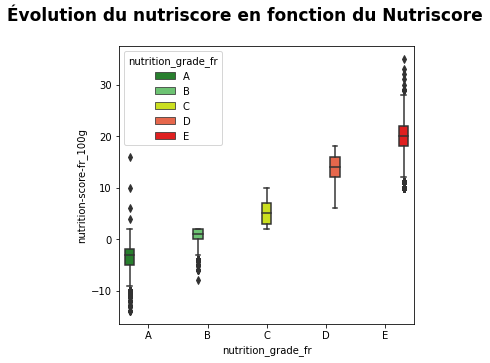

In [19]:
plt.figure(figsize=(5,5))
plt.suptitle("Évolution du nutriscore en fonction du Nutriscore", size=size_title_graph, va='top', 
             weight='bold', y=y_title)

sns.boxplot(data=df, x=nutrigrade, y=nutriscore, hue=nutrigrade, palette=dict_colors)

plt.tight_layout()
plt.savefig("img\\Évolution du nutriscore en fonction du Nutriscore.png")
plt.show();

#### 2. Test de normalité des distributions

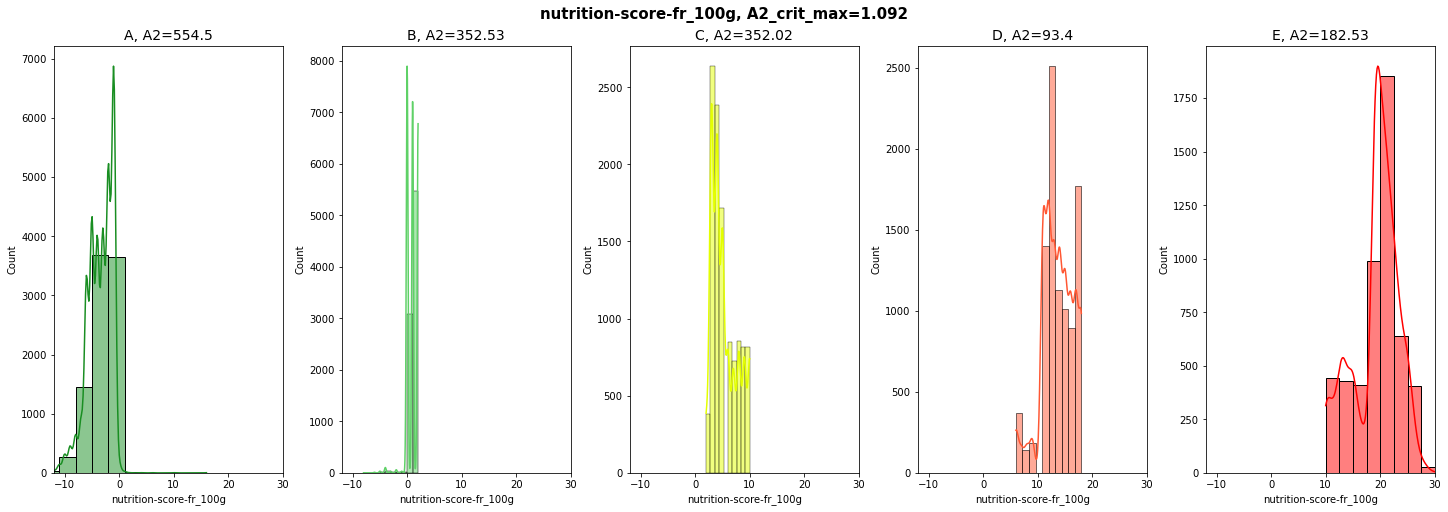

In [20]:
fig = plt.figure(figsize=(20, 7), constrained_layout=True)

subset = df[[nutriscore, nutrigrade]]
dict_Anderson_nutri = {Nutriscore_groupes[x]:anderson(subset[subset[nutrigrade]==Nutriscore_groupes[x]][nutriscore])[0]
              for x in range(k)}
dict_Anderson_nutri['A2_max'] = anderson(subset[subset[nutrigrade]=='A'][nutriscore])[1].max()

plt.suptitle(f"{nutriscore}, A2_crit_max={dict_Anderson_nutri['A2_max']}", size=15, weight='bold')

axs = fig.subplots(1, k)

for j, ax in enumerate(axs):
    grp = Nutriscore_groupes[j]

    ax.set_title(f"{grp}, A2={dict_Anderson[grp]}", size=14, y=1)
    ax.set_xlim(-12,30)
    sns.histplot(data=subset[subset[nutrigrade]==grp][nutriscore], 
                 ax=ax, bins=10, color=dict_colors[grp], kde=True)
        
plt.savefig("img\Statistique d'Anderson pour les distributions du nutriscore au sein des différentes groupes Nutriscore.png")

Comme les histogrammes nous en laissaient douter,  <b>nous pouvons rejeter l'hypothèse de normalité des lois de distribution des sous-échantillons</b> car la statistique d'Anderson <b>A2</b> est chaque fois plus grande que la valeur critique maximale.

#### 3. Test d'homoscédasticité des sous-échantillons

In [21]:
Levene_nutriscore = []
dict_samples_nutriscore = {}


for grp in Nutriscore_groupes:
    dict_samples_nutriscore[grp] = df[df[nutrigrade]==grp][nutriscore].dropna().reset_index(drop=True)

Levene_nutriscore.append(levene(dict_samples_nutriscore['A'], dict_samples_nutriscore['B'], dict_samples_nutriscore['C'],
                                   dict_samples_nutriscore['D'], dict_samples_nutriscore['E']))


print("La p-value associée au test d'égalité des variances du {} est {}.".format(nutriscore, Levene_nutriscore[0].pvalue))

La p-value associée au test d'égalité des variances du nutrition-score-fr_100g est 0.0.


De toute évidence, la p-value associée à tous nos test d'égalité des variances entre les sous-échantillons des valeurs nutritionnelles en fonction du groupe Nutriscore est inférieure à la valeur seuil de <b>p=0.05</b>, <b>nous rejetons donc l'hypothèse d'égalité des écart-types</b>.

Étant donné la non réalisation des 2 conditions nécessaires pour effectuer un test ANOVA, nous proposons de réaliser un test de <b>Kruskal-Wallis<b/>:

In [22]:
Kruskal_nutriscore = []

Kruskal_nutriscore.append(kruskal(dict_samples_nutriscore['A'],dict_samples_nutriscore['B'],dict_samples_nutriscore['C'],
                                         dict_samples_nutriscore['D'],dict_samples_nutriscore['E']))


print("La p-value associée au test d'égalité des médianes de {} est {}.".format(nutriscore, Kruskal_nutriscore[0].pvalue))

La p-value associée au test d'égalité des médianes de nutrition-score-fr_100g est 0.0.


De toute évidence, la p-value est inférieure à la valeur seuil de <b>p=0.05</b>, <b>nous rejetons donc l'hypothèse d'égalité des médianes</b> : au moins une médiane d'un des sous-échantillons est significativement différente de celle d'un autre.

Nous pourrions réaliser le test de <b>Kruskal-Wallis</b> sur chacune des 3 paires différentes tirées des 5 sous-échantillons pour nous assurer que la médiane de chaque échantillon est bien significativement différente de celle des autres, mais nous ne le ferons pas ici (3 parmi 5 possibilités différentes soit 10 combinaisons).

#### Étudions la relation entre le nutriscore et le nombre d'éléments constitutifs des produits:

In [23]:
df_constitution = df[[cols_ingredients[1], cols_additifs[0], cols_palm[0], cols_palm[1], nutrigrade]]

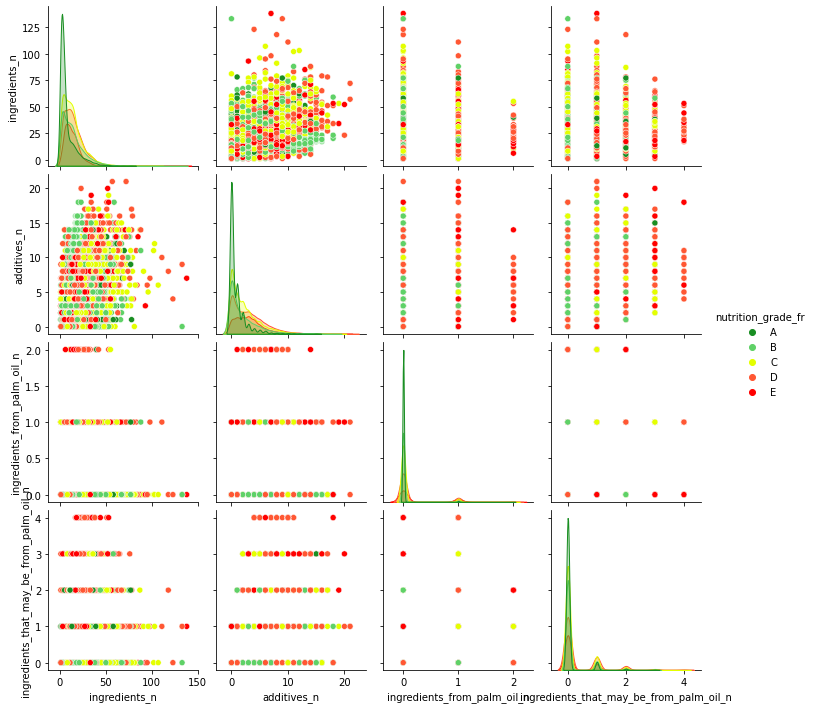

In [24]:
sns.pairplot(df_constitution, hue=nutrigrade, palette=dict_colors)

Sur le graphique nous pouvons observer les :

- Plus le Nutriscore est bon, moins les distribution des variables semblent étalées vers les grandes valeurs, et plutôt concentrées sur les faibles
- En particulier, il semble que plus un produit contient d'ingrédients provenant ou provenant potentiellement de l'huile de palme, moins il a tendance à être constitué d'un grand nombre d'ingrédients : 
    - <u>l'huile de palme est-elle un substitut efficace à la combinaison de plusieurs autres ingrédients ?</u>
    - <u>ces produits à grand nombre d'ingrédients issus de l'huile de palme ayant tendance à appartenir à un groupe Nutriscore élevé, un "mauvais produit" serait-il donc constitué de moins d'ingrédients mais de plus mauvais ingrédients ?</u>

In [25]:
def distribution_one_var_Nutriscore(col_name):

    fig = plt.figure(figsize=(20, 6), constrained_layout=True)

    subset = df[[col_name, nutrigrade]]

    plt.suptitle(f"Distribution de {col_name} par produit en fonction du groupe Nutriscore", size=size_title_graph, weight='bold')

    axs = fig.subplots(1, k)

    for j, ax in enumerate(axs):
        grp = Nutriscore_groupes[j]

        ax.set_title(f"{grp}", size=14, y=1)
        sns.histplot(data=subset[subset[nutrigrade]==grp][col_name], 
                     ax=ax, bins=50, color=dict_colors[grp], kde=True)

    plt.savefig(f"img\\Distribution de {col_name} par produit en fonction du groupe Nutriscore.png")

def boxplot_one_var_Nutriscore(col_name):
    plt.figure(figsize=(6,6))
    plt.suptitle(f"Évolution de {col_name} en fonction du Nutriscore", size=size_title_graph, weight='bold')
    sns.boxplot(data=df, x=nutrigrade, y=col_name, hue=nutrigrade, palette=dict_colors)
    plt.legend(loc='upper left')
    plt.savefig(f"img\\Évolution de {col_name} en fonction du Nutriscore(boxplot).png")
    
def catplot_one_var_nutriscore(col_name):
    plt.figure(figsize=(6,6))
    plt.suptitle(f"Évolution de {col_name} en fonction du Nutriscore", size=size_title_graph, weight='bold')
    ax1 = sns.catplot(data=df, x=col_name, y=nutriscore, hue=nutrigrade, palette=dict_colors, legend=False)
    plt.legend(loc='lower right')
    plt.savefig(f"img\\Évolution de {col_name} en fonction du Nutriscore(scatterplot).png")
    plt.show();

def Kruskal_test_one_var_Nutriscore_samples(col_name):
    Kruskal_list = []
    dict_samples = {}

    for grp in Nutriscore_groupes:
        dict_samples[grp] = df[df[nutrigrade]==grp][col_name].dropna().reset_index(drop=True)


    Kruskal_list.append(kruskal(dict_samples['A'],dict_samples['B'],dict_samples['C'], dict_samples['D'],dict_samples['E']))


    print("La p-value associée au test d'égalité des médianes de {} est {}.".format(col_name, Kruskal_list[0].pvalue))

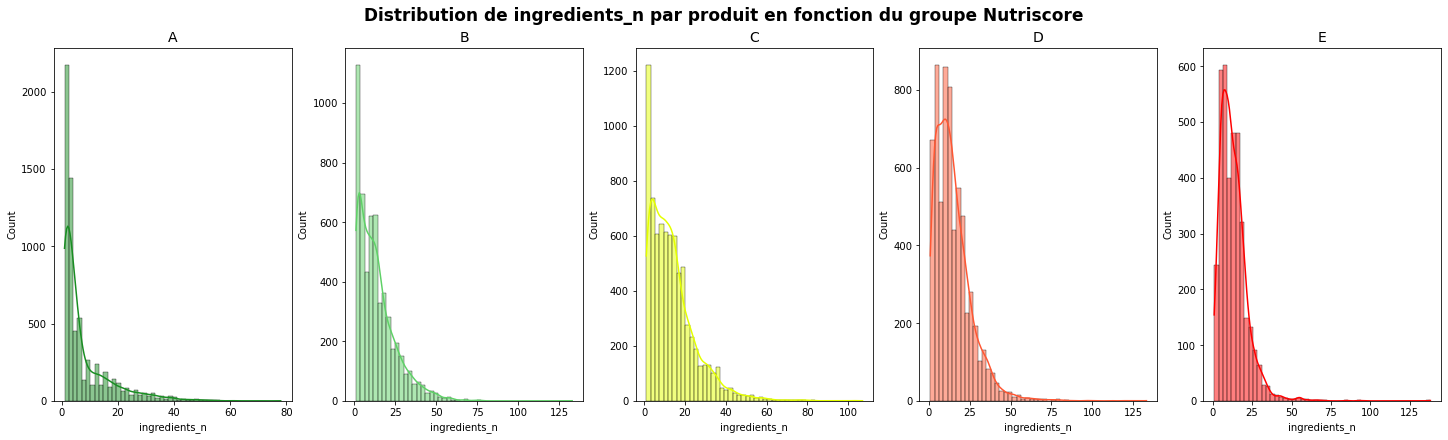

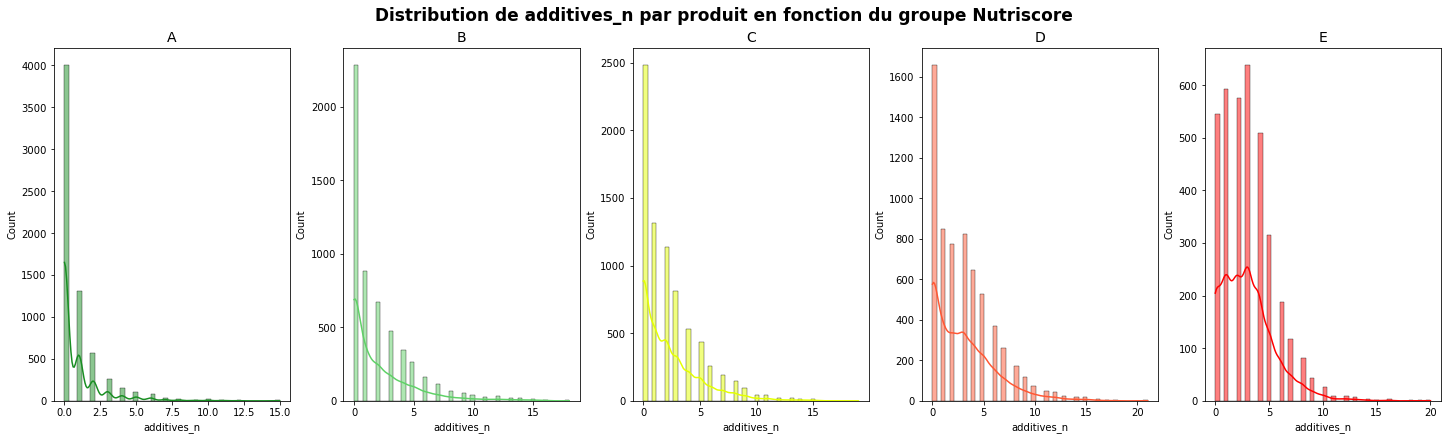

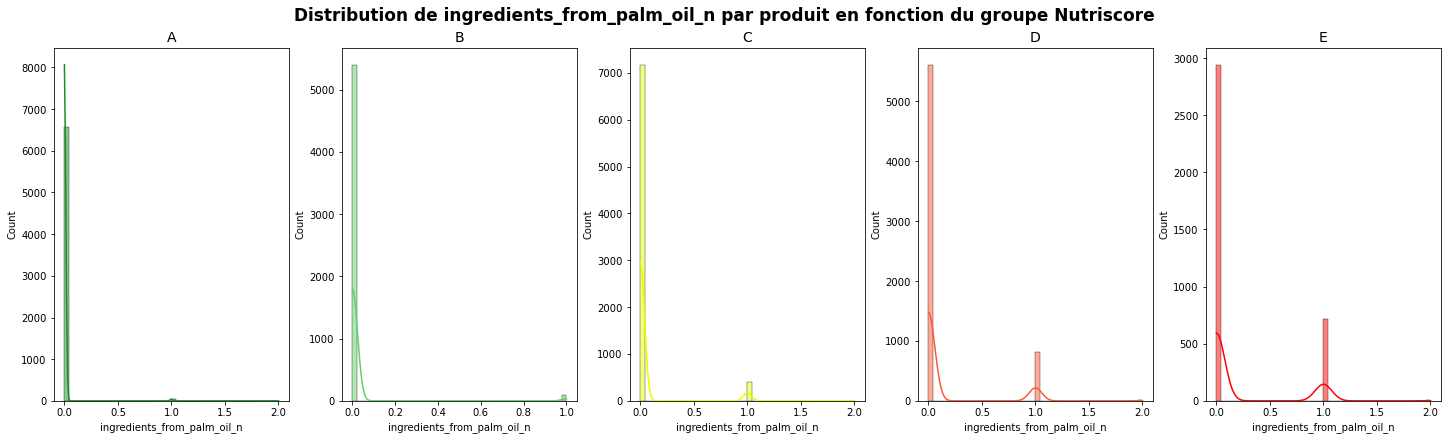

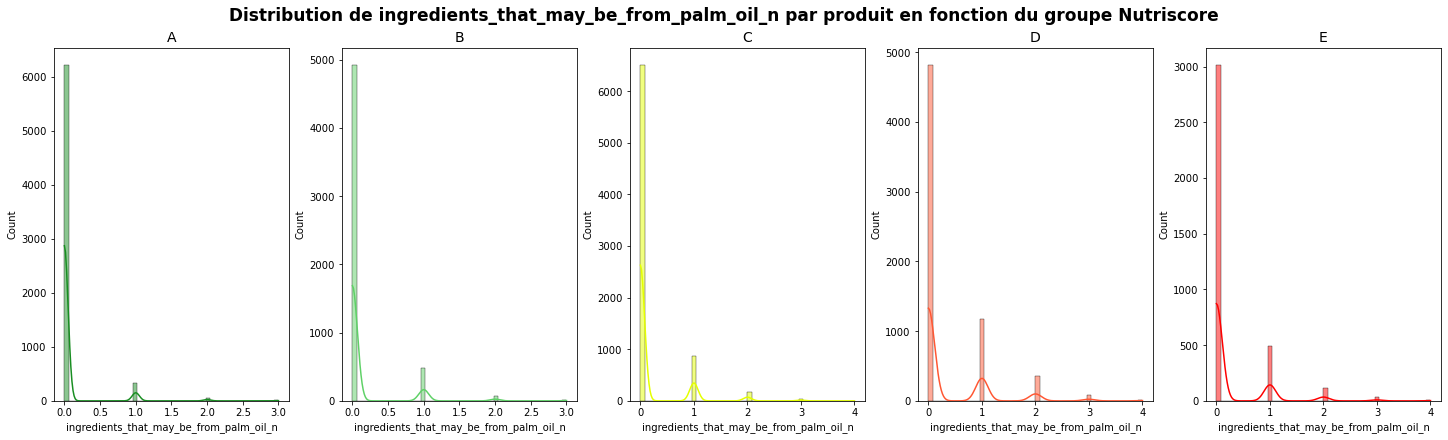

In [26]:
for col in df_constitution.columns.tolist()[:-1]:
    distribution_one_var_Nutriscore(col)

Les graphiques ci-dessus confirment une partie de nos observations plus hauts :
- Plus un produit appartient à un groupe Nutriscore mauvais, plus il a tendance à contenir un nombre plus élevé d'ingrédients issus de l'huile de palme
- De même pour les additifs, et les ingrédients

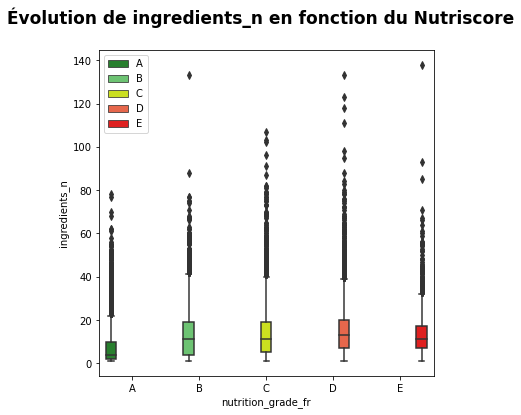

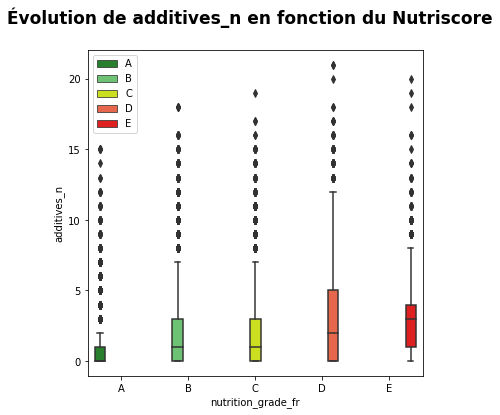

In [27]:
for col in df_constitution.columns.tolist()[:2]:
    boxplot_one_var_Nutriscore(col)

<Figure size 432x432 with 0 Axes>

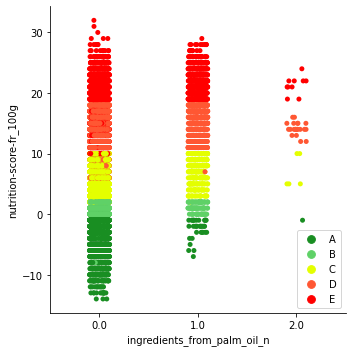

<Figure size 432x432 with 0 Axes>

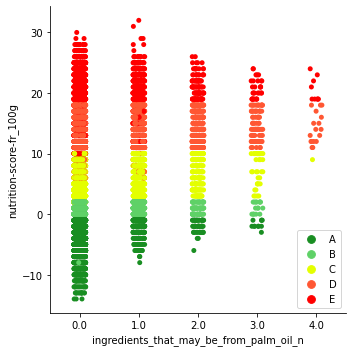

In [28]:
for col in cols_palm:
    catplot_one_var_nutriscore(col)

#### Uniquement pour le nombre d'ingrédients, nous allons tester la significativité des différences de médianes

La distribution des sous-échantillons du nombre d'ingrédients dans les différents groupes n'est visiblement pas normale, nous allons donc directement réaliser un test de <b>Kruskal-Wallis</b> pour tester la significativité de la différence de leurs médianes :

In [29]:
Kruskal_test_one_var_Nutriscore_samples(cols_ingredients[1])

La p-value associée au test d'égalité des médianes de ingredients_n est 0.0.


Étant donné notre graphique de boîtes à moustache, nous décidons de refaire le test de Kruskal-Wallis en excluant le groupe Nutriscore 'A' :

La p-value est toujours inférieur au seuil p=0.05, nous pouvons donc rejeter avec un risque de première espèce valant 5%, l'hypothèse selon laquelle le Nutriscore n'a pas d'effet sur la médiane du nombre d'ingrédients par produits.

<u>En l'occurence, plus le Nutriscore est mauvais, plus le nombre d'ingrédients a tendance à être élevé</u>.

#### Analyse en composantes principales

Pour la suite de notre analyse, nous allons récupérer les valeurs nutritionnelles imputées grâce à 'Knnimputer' dans le fichier de préparation des données.

In [30]:
Knn4=pd.read_csv('results\Xknn4.csv', index_col="Unnamed: 0")

In [31]:
df_acp = df[cols_val_nutri].copy()

In [32]:
df_acp.loc[:,cols_val_nutri]=Knn4.loc[:,cols_val_nutri]

In [33]:
Scaler = StandardScaler()

In [34]:
df_acp_scaled = Scaler.fit_transform(df_acp)

In [35]:
pca = PCA(n_components=len(cols_val_nutri))

In [36]:
pca.fit(df_acp_scaled)

PCA(n_components=7)

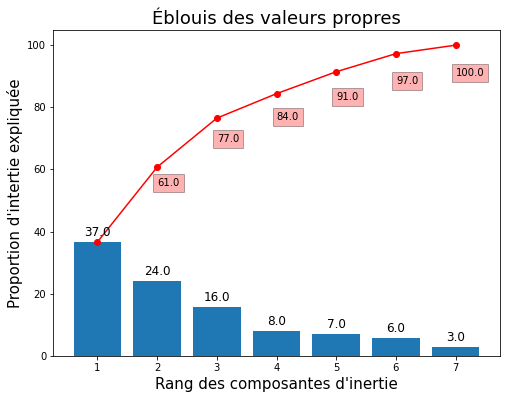

In [37]:
ACP_functions.display_scree_plot(pca)

In [38]:
df_acp_proj = pca.transform(df_acp_scaled)

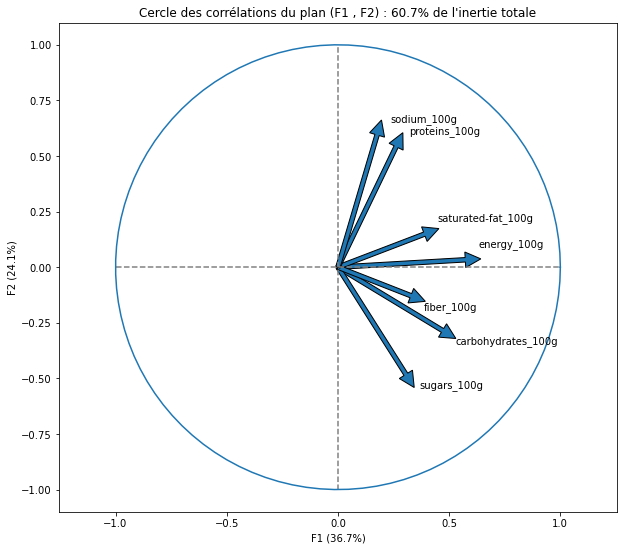

In [39]:
ACP_functions.display_corr_circle(pca, (0,1), cols_val_nutri)

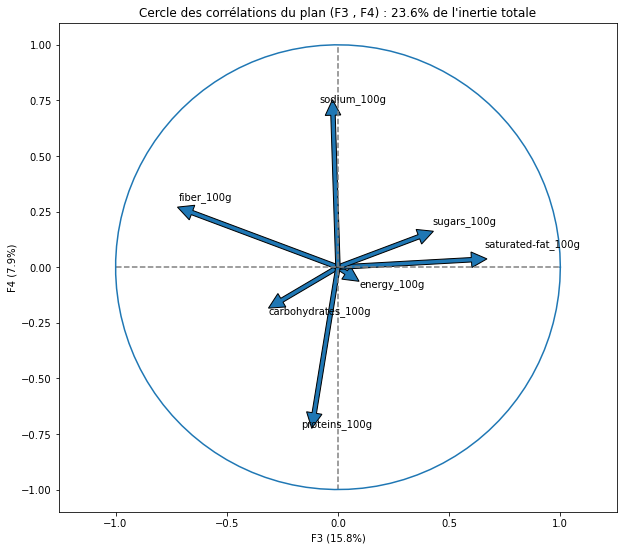

In [40]:
ACP_functions.display_corr_circle(pca, (2,3), cols_val_nutri)

In [41]:
index_na = df[df[nutrigrade].isna()].index
df_acp_proj = np.asarray(pd.DataFrame(df_acp_proj, columns=cols_val_nutri).drop(index=index_na))

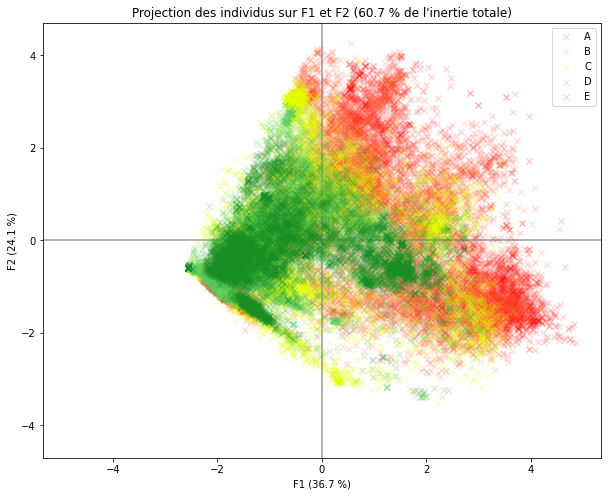

In [42]:
ACP_functions.display_factorial_planes(df_acp_proj, 
                                       (0,1), 
                                       pca, 
                                       clusters=df[nutrigrade].dropna().tolist(),
                                       dict_colors=dict_colors,
                                       dict_order={'A':4, 'B':3, 'C':2, 'D':1, 'E':0},
                                       alpha=0.15,
                                       marker='x')

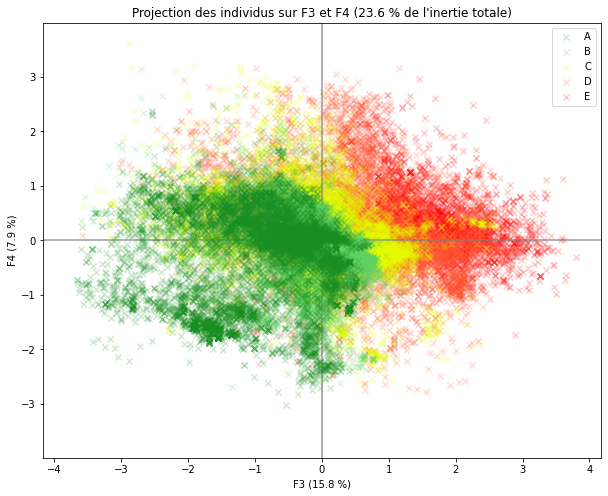

In [43]:
ACP_functions.display_factorial_planes(df_acp_proj, 
                                       (2,3), 
                                       pca, 
                                       clusters=df[nutrigrade].dropna().tolist(),
                                       dict_colors=dict_colors,
                                       dict_order={'A':4, 'B':3, 'C':2, 'D':1, 'E':0},
                                       alpha=0.2,
                                       marker='x')

In [44]:
columns_to_drop = ['code', 'url', 'last_modified_datetime', 'product_name', 'brands','origins','manufacturing_places', 'stores', 'ingredients_text', 'additives_fr', 'codes_additifs', 
                  'additif_niveau_danger', nutrigrade, 'pnns_groups_1', 'alcool', 'image_small_url']

Étant donné la dispersion des valeurs manquantes de notre jeu de données, nous allons réaliser des analyses en composante principales par partie 

1. ACP1 entre les valeurs nutritionnelles

2. ACP2 avec 
    - les valeurs nutritionnelles
    - les colonnes additif et huile de palme
    - les colonnes emballage
    - les colonnes catégories
    - 